In [ ]:
# import the necessary dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, LSTM, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

%matplotlib inline

In [ ]:
# Download stopwords from nltk module
nltk.download('stopwords')

# Download wordnet from nltk module
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

We'll be using 3 different datasets to build our main corpus.

1. Kaggle Disaster Tweets dataset linked [ here](https://www.kaggle.com/c/nlp-getting-started/). 

2. Nepal Earthquake Tweets dataset (from CrisisNLP)

3. Queensland Flood Tweets dataset (from CrisisNLP)

In [ ]:
# Load kaggle data
kaggle_train = pd.read_csv('/content/drive/My Drive/ML_Datasets/Disaster Tweets/Data/train.csv')

In [ ]:
# Look at the first 3 observations of the kaggle train dataset
kaggle_train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
# Load Nepal earthquake data 
nepal_earthquake = pd.read_csv('/content/drive/MyDrive/Capstone Project/CAPSTONE PROJECT.rar (Unzipped Files)/CAPSTONE PROJECT/Capstone Project Datasets/ACL_ICWSM_2018_datasets/ACL_ICWSM_2018_datasets/nepal/2015_Nepal_Earthquake_train.tsv', sep='\t', encoding='latin1')

In [ ]:
# Look at the first 3 observations
nepal_earthquake.head(3)

,tweet_id,text,label
0,591902739002560512,RT @AnupKaphle: #Nepal's prime minister addres...,relevant
1,592939706788216832,@jonsnowC4 So have we; read our friends blog f...,relevant
2,592591542168252416,Lend a helping hand if you can #Nepal https://...,relevant


In [ ]:
# Drop rows whose tweets_ids have the wrong data
idx = []

remove_ids = [593232206622928896, 591911255729786880, 592768434628382720, 592654592157949952, 593261661546487808, 592589809417322496, 592590595975053312]

for i in range(nepal_earthquake.shape[0]):
  if nepal_earthquake['tweet_id'][i] in remove_ids:
    idx.append(i)

nepal_earthquake = nepal_earthquake.drop(idx, axis=0)

In [ ]:
# Load the Queensland floods data
queensland_floods = pd.read_csv('/content/drive/MyDrive/Capstone Project/CAPSTONE PROJECT.rar (Unzipped Files)/CAPSTONE PROJECT/Capstone Project Datasets/ACL_ICWSM_2018_datasets/ACL_ICWSM_2018_datasets/queensland/2013_Queensland_Floods_train.tsv', sep='\t', encoding='latin1')

In [ ]:
# Look at the first 3 observations
queensland_floods.head(3)

,tweet_id,text,label
0,295541465013182465,I just though about the night I went clubbing ...,not_relevant
1,295485717465935873,Looks like its going to be another long night ...,not_relevant
2,297292225811972097,@LaniiBanani hahahaha I just told him id have ...,not_relevant


In [ ]:
def labelEncode(label):
  """ Encode labels: 1 for relevant and 0 for not_relevant"""

  return 1 if label == "relevant" else 0

In [ ]:
# Encode nepal earthquake labels
nepal_earthquake['target'] = nepal_earthquake['label'].apply(lambda x: labelEncode(x))

In [ ]:
# Encode queensland floods labels
queensland_floods['target'] = queensland_floods['label'].apply(lambda x: labelEncode(x))

In [ ]:
# Drop irrelevant columns from the nepal earthquake data
nepal_earthquake = nepal_earthquake.drop(["tweet_id", "label"], axis=1)

In [ ]:
# Drop irrelevant columns from the queensland floods data
queensland_floods = queensland_floods.drop(["tweet_id", "label"], axis=1)

In [ ]:
# Drop irrelevant columns from the kaggle train data
kaggle_train = kaggle_train.drop(["id", "keyword", "location"], axis=1)

In [ ]:
# Concatenate the 3 datasets (kaggle_train, nepal_earthquake, queensland_floods) to create the train corpus
train_corpus = pd.concat([kaggle_train, nepal_earthquake, queensland_floods], ignore_index=True)

In [ ]:
# Load test set from kaggle
test_file = '/content/drive/My Drive/ML_Datasets/Disaster Tweets/Data/test.csv'
test_corpus = pd.read_csv(test_file, encoding='latin1')

In [ ]:
# Display first 3 observations from the test data
test_corpus.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [ ]:
# Split the train data into train examples and labels
train_labels = train_corpus["target"]
train_text = train_corpus["text"]

In [ ]:
# Get test examples and save the ids from the test observations
test_text = test_corpus["text"]
test_ids = test_corpus['id']

Data Preprocessing and Feature Engineering

In [ ]:
# Define some common contractions in English 
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


In [ ]:
# Define some preprocessing helper functions

def removeHyperLinks(words):
  """ Remove hyperlinks from the texts """

  new_words = []
  for word in words:
    new_word = re.sub(r"http\S+", "", word)
    if new_word != '':
      new_words.append(new_word)
  return new_words

def removeUsernames(words):
  """ Remove @username from the tweet"""

  new_words = []
  for word in words:
    new_word = re.sub('@[\w]+','',word)
    if new_word != '':
      new_words.append(new_word)
  return new_words

def removeHashtags(words):
  """ Remove #hashtags symbol from the tweet"""

  new_words = []
  for word in words:
    new_word = re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", '', word)
    if new_word != '':
      new_words.append(new_word)
  return new_words

def removePunctuation(words):
    """Remove punctuation from the tweet"""

    new_words = []
    for word in words:
      new_word = re.sub(r'[^\w\s]', '', word)
      if new_word != '':
        new_words.append(new_word)
    return new_words

def expandContractions(words):
  """ Expand contractions from the tweet"""

  new_words = []
  for word in words:
    expanded = contractions.get(word, word)
    new_word = expanded.split(" ")
    new_words = new_words + new_word
  
  return new_words

def removeStopWords(words):
    """Remove stop words from the tweet"""

    new_words = []
    for word in words:
      if word not in stopwords.words('english'):
        new_words.append(word)
    return new_words

def lemmatizeWords(words):
    """Lemmatize the words"""
    
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
      lemma = lemmatizer.lemmatize(word, pos='v')
      lemmas.append(lemma)
    return lemmas

def removeRT(words):
  """Remove RT which indicates the tweet is a retweet"""

  new_words = []
  for word in words:
    new_word = re.sub(r'RT', '', word)
    if new_word != '':
        new_words.append(new_word)
  return new_words


def preprocessTweets(tweet):
  """ Combines all preprocessing steps for the tweets"""
  tweet = tweet.split(" ")
  
  tweet = removeHyperLinks(tweet)
  tweet = removeUsernames(tweet)
  tweet = removeHashtags(tweet)
  tweet = expandContractions(tweet)
  tweet = removeStopWords(tweet)
  tweet = removePunctuation(tweet)
  tweet = removeRT(tweet)
  tweet = lemmatizeWords(tweet)

  return tweet

In [ ]:
# Preprocess tweets from the train text
train_text = train_text.apply(lambda x: preprocessTweets(x))

In [ ]:
# Check to ensure tweets have been preprocessed
train_text[7610:7620]

7610             [M194, 0104, UTC5km, S, Volcano, Hawaii]
7611    [Police, investigate, ebike, collide, car, Lit...
7612    [The, Latest, More, Homes, Razed, Northern, Ca...
7613    [Nepals, prime, minister, address, country, 1s...
7614             [So, read, friends, blog, Lamjung, work]
7615                            [Lend, help, hand, Nepal]
7616    [theyve, manage, reach, Kathmandu, help, guide...
7617    [Israel, Sending, Aid, Teams, Nepal, After, Qu...
7618    [All, Shiv, Sena, MPs, give, 1, months, salary...
7619    [British, archeologist, terrify, narrowly, esc...
Name: text, dtype: object

In [ ]:
# Preprocess tweets from the test text
test_text = test_text.apply(lambda x: preprocessTweets(x))

In [ ]:
# One hot encode the train labels
train_labels = to_categorical(train_labels)
train_labels[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
# Define a function to reverse one hot encoded labels
def reverseEncoded(encoded_labels):
  return np.argmax(encoded_labels, axis=1)

In [ ]:
# Define the diectory to the GloVe
GLOVE_DIR = "/content/drive/MyDrive/ML_Datasets/Disaster Tweets/glove.6B.100d.txt"

In [ ]:
# Create an embeddings dictionary from the GloVe vectors
def createGloveEmbeddings():
  embeddings_dict = {}
  f = open(GLOVE_DIR, encoding="utf8")
  for line in f:
      values = line.split()
      word = values[0]
      try:
          coefs = np.asarray(values[1:], dtype='float32')
      except:
          pass
      embeddings_dict[word] = coefs
  f.close()
  return embeddings_dict

In [ ]:
# Concatenate our train and test sets, tokenize the tweets and create a vocabulary of our corpus
def prepare_model_input(tokenizer, embedding_dict, X_train, X_test=None, max_sequence_len=50):
    if X_test is not None: 
      text = np.concatenate((X_train, X_test), axis=0)
      text = np.array(text)
    else:
      text = X_train
    
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=max_sequence_len) 
    print('Found {} unique tokens.'.format(len(word_index)))

    X_train_Glove = text[:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]

    print('Total {} word vectors.'.format(len(embeddings_dict)))

    return (X_train_Glove, X_test_Glove, word_index)

In [ ]:
# Build weight matrix from the vocabulary and embeddings dictionary
def buildWeightMatrix(word_index, embeddings_dict, EMBEDDING_DIM=100,):
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape")
                exit(1)
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

Modeling

In [ ]:
# Build a Bidirectional Long Short-Term Memory (BLSTM) model
def build_bilstm(word_index, embeddings_dict, embedding_matrix, nclasses,  max_sequence_len, EMBEDDING_DIM=50):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_sequence_len,
                                trainable=False))
    
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dropout(0.2))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.0001),
                      metrics=['accuracy'])
    return model

In [ ]:
# Build a CNN model for text classification
def build_cnn(word_index, embeddings_dict, embedding_matrix, nclasses,  max_sequence_len, EMBEDDING_DIM=50):
  model = Sequential()

  model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_sequence_len,
                                trainable=False))
  
  model.add(SpatialDropout1D(0.2))
  model.add(Conv1D(64, kernel_size=3, activation="relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(128, kernel_size=3, activation="relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(256, kernel_size=3, activation="relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(512, kernel_size=3, activation="relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(nclasses, activation='softmax'))

# Compile the model 
  model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.0001),
                    metrics=['accuracy'])
  return model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Create a tokenizer object
tokenizer = Tokenizer() 

X_train = train_text
X_test = test_text

max_sequence_len = 50

embeddings_dict = createGloveEmbeddings()

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index = prepare_model_input(tokenizer, embeddings_dict, X_train, X_test, max_sequence_len=max_sequence_len)
print("Done!")

# Split the training data into a train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train_Glove, train_labels, test_size = 0.2, random_state=0)

# Create and initialize the embedding matrix
embedding_matrix = buildWeightMatrix(word_index, embeddings_dict, EMBEDDING_DIM = 100)

Preparing model input ...
Found 28021 unique tokens.
Total 400000 word vectors.
Done!


In [ ]:
# Save the tokenizer object
tokenizer_file = "tokenizer.pkl"

pickle.dump(tokenizer, open(tokenizer_file, "wb"))

In [ ]:
# Create a callback to stop training once validation loss stops improving
earlystopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="auto",
)

In [ ]:
cnn_model = build_cnn(word_index, embeddings_dict, embedding_matrix, 2, max_sequence_len, EMBEDDING_DIM = 100)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2802200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 64)            19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0

In [ ]:
# Train the cnn model
BATCH_SIZE = 128
history = cnn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, batch_size=BATCH_SIZE, callbacks=[earlystopping])

Epoch 1/50
129/129 [==============================] - 1s 9ms/step - loss: 0.6979 - accuracy: 0.5202 - val_loss: 0.6844 - val_accuracy: 0.5778
Epoch 2/50
129/129 [==============================] - 1s 6ms/step - loss: 0.6688 - accuracy: 0.5932 - val_loss: 0.6465 - val_accuracy: 0.6185
Epoch 3/50
129/129 [==============================] - 1s 6ms/step - loss: 0.5976 - accuracy: 0.6856 - val_loss: 0.5637 - val_accuracy: 0.7279
Epoch 4/50
129/129 [==============================] - 1s 6ms/step - loss: 0.5619 - accuracy: 0.7251 - val_loss: 0.5504 - val_accuracy: 0.7359
Epoch 5/50
129/129 [==============================] - 1s 6ms/step - loss: 0.5538 - accuracy: 0.7247 - val_loss: 0.5419 - val_accuracy: 0.7423
Epoch 6/50
129/129 [==============================] - 1s 6ms/step - loss: 0.5438 - accuracy: 0.7329 - val_loss: 0.5296 - val_accuracy: 0.7467
Epoch 7/50
129/129 [==============================] - 1s 6ms/step - loss: 0.5368 - accuracy: 0.7391 - val_loss: 0.5209 - val_accuracy: 0.7513
Epoch 

In [ ]:
# Save CNN model
cnn_model.save("cnn_model.h5")

Model Evaluation

In [ ]:
# Evaluate the CNN model using the validation set
loss, accuracy = cnn_model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)
print("Model Loss: {:.2f}\nModel Accuracy: {:.2f}".format(loss, accuracy))

33/33 [==============================] - 0s 3ms/step - loss: 0.4880 - accuracy: 0.7700
Model Loss: 0.49
Model Accuracy: 0.77


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Use the CNN model to make predictions
y_preds = cnn_model.predict(X_validation)

# Generate classes from the one-hot encoded predictions
y_preds_classes = reverseEncoded(y_preds)

In [ ]:
def visualizeReports(y_validation, y_preds_classes, labels, model_name):
  # Visualize the classification report so we can analyze accuracy, precision, recall and f1 score
  print("Classification Report for {} \n{} ".format(model_name, classification_report(reverseEncoded(y_validation), y_preds_classes, target_names=labels)))

  # Plot a confusion matrix of the predictions
  confusion_mx = confusion_matrix(reverseEncoded(y_validation), y_preds_classes)
  plt.title("Confusion Matrix for " + model_name)
  sns.heatmap(confusion_mx, xticklabels=labels, yticklabels=labels, annot=True, fmt=".0f", cmap=plt.cm.Blues)

In [ ]:
# Define the class labels from the data
class_labels = ["0", "1"]

Classification Report for CNN 
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      2147
           1       0.86      0.62      0.72      1958

    accuracy                           0.77      4105
   macro avg       0.79      0.76      0.76      4105
weighted avg       0.79      0.77      0.76      4105
 


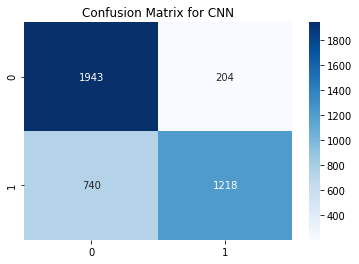

In [ ]:
visualizeReports(y_validation, y_preds_classes, class_labels, "CNN")

In [ ]:
# Create a BiLSTM model
bilstm_model = build_bilstm(word_index, embeddings_dict, embedding_matrix, 2, max_sequence_len, EMBEDDING_DIM = 100)
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2802200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 300)           301200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 300)           541200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 300)          

In [ ]:
# Train the bilstm model
BATCH_SIZE = 128
history = bilstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, batch_size=BATCH_SIZE, callbacks=[earlystopping])

Epoch 1/40
129/129 [==============================] - 9s 71ms/step - loss: 0.5662 - accuracy: 0.7004 - val_loss: 0.4664 - val_accuracy: 0.7876
Epoch 2/40
129/129 [==============================] - 7s 53ms/step - loss: 0.4796 - accuracy: 0.7766 - val_loss: 0.4494 - val_accuracy: 0.7978
Epoch 3/40
129/129 [==============================] - 7s 53ms/step - loss: 0.4641 - accuracy: 0.7851 - val_loss: 0.4432 - val_accuracy: 0.7968
Epoch 4/40
129/129 [==============================] - 7s 53ms/step - loss: 0.4553 - accuracy: 0.7897 - val_loss: 0.4360 - val_accuracy: 0.7976
Epoch 5/40
129/129 [==============================] - 7s 53ms/step - loss: 0.4514 - accuracy: 0.7931 - val_loss: 0.4411 - val_accuracy: 0.7937
Epoch 6/40
129/129 [==============================] - 7s 53ms/step - loss: 0.4449 - accuracy: 0.7930 - val_loss: 0.4287 - val_accuracy: 0.8017
Epoch 7/40
129/129 [==============================] - 7s 53ms/step - loss: 0.4394 - accuracy: 0.7964 - val_loss: 0.4422 - val_accuracy: 0.8005

In [ ]:
# Save CNN model
bilstm_model.save("bilstm_model.h5")

In [ ]:
# Evaluate the bilstm model
loss, accuracy = bilstm_model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)
print("Model Loss: {:.2f}\nModel Accuracy: {:.2f}".format(loss, accuracy))

33/33 [==============================] - 1s 18ms/step - loss: 0.4074 - accuracy: 0.8171
Model Loss: 0.41
Model Accuracy: 0.82


In [ ]:
# Use the bilstm model to make predictions
y_preds = bilstm_model.predict(X_validation)

# Generate classes from the one-hot encoded predictions
y_preds_classes = reverseEncoded(y_preds)

Classification Report for BiLSTM 
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      2147
           1       0.86      0.74      0.79      1958

    accuracy                           0.82      4105
   macro avg       0.82      0.81      0.81      4105
weighted avg       0.82      0.82      0.82      4105
 


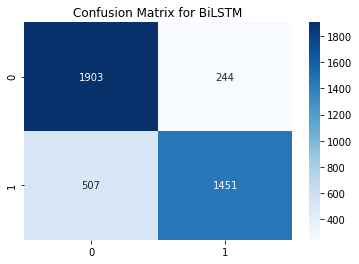

In [ ]:
visualizeReports(y_validation, y_preds_classes, class_labels, "BiLSTM")

In [ ]:
# Make predictions on the test data using the bilstm model
y_preds_test = bilstm_model.predict(X_test_Glove, batch_size=BATCH_SIZE)

In [ ]:
# Generate classes from the one-hot encoded predictions
y_preds_classes = reverseEncoded(y_preds_test)

Link to Web App: [link text](https://disaster-tweets-model.herokuapp.com/)